# Imports

In [1]:
#!pip install obonet  numpy pandas matplotlib  sklearn python-bidi arabic_reshaper 
#!pip install 'plotnine[all]' # we use this package for plot figures like ggplot2
#!pip install plotnine         
#!wget http://purl.obolibrary.org/obo/go.obo

In [37]:
#from plotnine import *
import requests,math,pickle
import networkx,obonet
import time
import numpy as np ,pandas as pd, matplotlib.pyplot as plt
import arabic_reshaper
import multiprocessing as mp
from sklearn.metrics.cluster import *
from bidi.algorithm import get_display
from functools import partial
from IPython.display import clear_output
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

In [38]:
def fa(text):
    return get_display(arabic_reshaper.reshape(u'%s' % str(text)))

In [39]:
num_cores = max(mp.cpu_count() - 3, 1)
Dataset_Name = "Toy_Low"
GO_ID_Column = "go_id"

!mkdir -p ./Output/{Dataset_Name}/figs

# Load contigs dataset

In [40]:
# load anonymous contigs and save in contigs data frame.
path_contigs = f"./Dataset/{Dataset_Name}/anonymous.fasta"

with open(path_contigs, 'r') as file:
    lines = [line for line in file.read().split('\n') if len(line) > 0]
    contigs = pd.DataFrame(
        {
            '#anonymous_gsa_id': lines[0::2],
            'contig': lines[1::2]
        },
        columns=['#anonymous_gsa_id', 'contig'])
    contigs['#anonymous_gsa_id'] = contigs['#anonymous_gsa_id'].apply(
        lambda x: x[1:])
del(lines)
contigs.head(2)

,#anonymous_gsa_id,contig
0,S|S1|C0,AGTAATAAGCGCCCGTTTCGCAGTCATTATAAAATCTCCCTTTTCA...
1,S|S1|C1,GCACCTGCGCGACCAGCGCCTTGGCGTGGATATAGCTGCCCTGGCC...


In [41]:
# load gold standard file and append to contig data frame.
path_gold_standard = f"./Dataset/{Dataset_Name}/mapping.tsv"
df = pd.read_csv(path_gold_standard, sep='\t')
contigs = pd.merge(contigs, df, how='inner', on='#anonymous_gsa_id')
contigs["contig_length"] = contigs["contig"].apply(lambda x: len(x))
print(f'contigs number :  {contigs.shape[0]}')
print(f"number of genomes:  {len(contigs['genome_id'].unique())}")
del(df)
contigs.head(2)

contigs number :  56168
number of genomes:  30


,#anonymous_gsa_id,contig,genome_id,tax_id,sequence_id,number_reads,contig_length
0,S|S1|C0,AGTAATAAGCGCCCGTTTCGCAGTCATTATAAAATCTCCCTTTTCA...,1394711.1,1394711,NC_023004.1,4,186
1,S|S1|C1,GCACCTGCGCGACCAGCGCCTTGGCGTGGATATAGCTGCCCTGGCC...,1230476.1,1230476,NZ_KE747857.1,14,617


##  Contigs description

In [42]:
# show description of contigs and contigs length histogram.
contigsLenght = contigs['contig'].apply(lambda x: len(x))

print(f'min : {contigsLenght.min()}')
print(f'max : {contigsLenght.max()}')
print(f'mean : {round(contigsLenght.mean(),2)}')
print(f'median : {round(np.median(contigsLenght),2)}')
print(f'1st quartiles : {round(np.percentile(contigsLenght, 25),2)}')
print(f'median : {round(np.median(contigsLenght),2)}')
print(f'3rd quartiles : {round(np.percentile(contigsLenght, 75),2)}')
print(f'standard deviation : {round(np.std(contigsLenght),2)}')
print(f'variance : {round(np.var(contigsLenght),2)}')

min : 100
max : 2780101
mean : 1730.46
median : 345.0
1st quartiles : 193.0
median : 345.0
3rd quartiles : 701.0
standard deviation : 19478.59
variance : 379415438.94


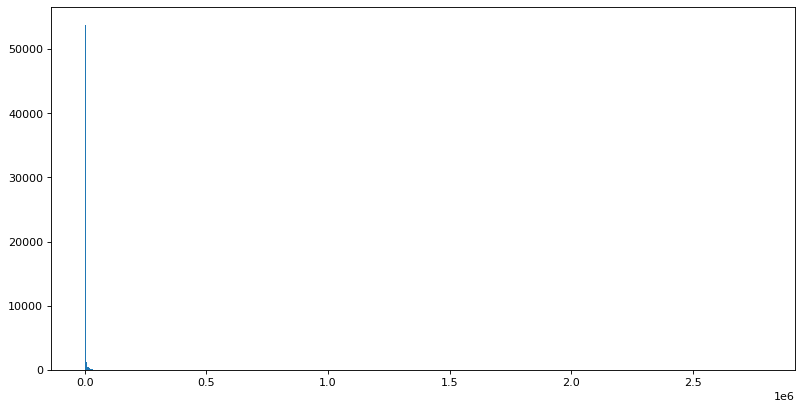

In [28]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(contigsLenght, bins=500)
plt.savefig(f"./Output/{Dataset_Name}/figs/histogram_lower_than_2000.svg")
plt.show()

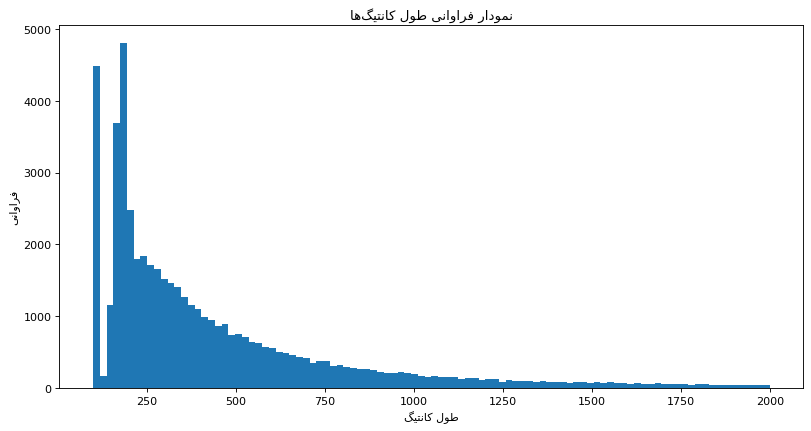

In [43]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(contigsLenght[contigsLenght < 2000], bins=100)
plt.xlabel(fa("طول کانتیگ"))
plt.ylabel(fa("فراوانی"))
plt.title(fa("نمودار فراوانی طول کانتیگ‌ها"))
plt.savefig(f"./Output/{Dataset_Name}/figs/histogram_lower_than_2000.svg")
plt.show()

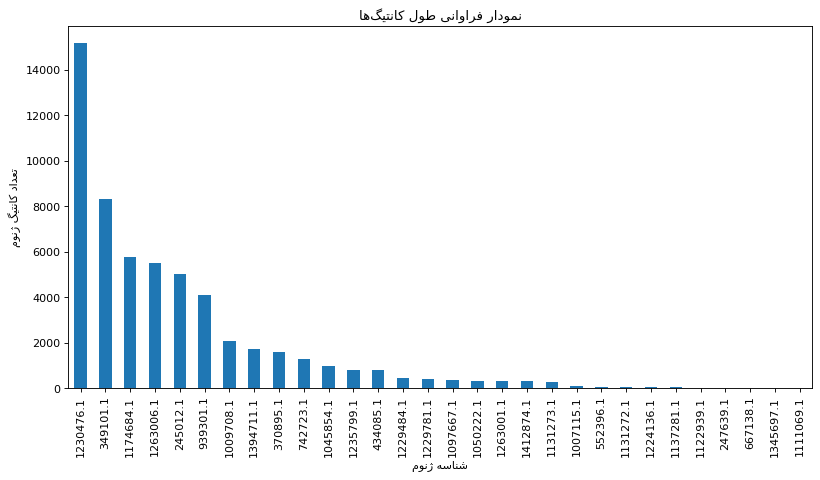

In [44]:
# show contig frequancy for every genome.
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
ax = contigs['genome_id'].value_counts().plot(kind='bar',
                                              title='Genome frequency')
plt.xlabel(fa("شناسه ژنوم"))
plt.ylabel(fa("تعداد کانتیگ ژنوم"))
plt.title(fa("نمودار فراوانی طول کانتیگ‌ها"))

plt.savefig(f"./Output/{Dataset_Name}/figs/genome_frequency.svg")
plt.show()

In [45]:
# save gold standard data as CAMI binning Bioboxes format.
!mkdir -p ./Temp/{Dataset_Name}/
path_gold_standard_output = f"./Temp/{Dataset_Name}/gold_standard"

contigs[['#anonymous_gsa_id', 'genome_id', 'tax_id',
         'contig_length']].to_csv(path_gold_standard_output, index=None, sep='\t')

with open(path_gold_standard_output, 'r') as file:
    file.readline()
    text = file.read()

with open(path_gold_standard_output, 'w', encoding='utf8') as file:
    file.write(
        "@Version:0.9.1\n@SampleID:gsa\n\n@@SEQUENCEID\tBINID\tTAXID\t_LENGTH\n"
        + text)

## Busybee method with threshold 0%

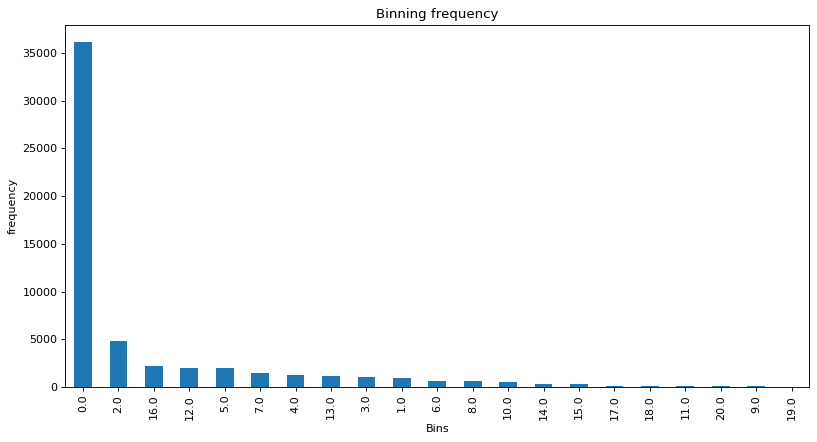

,#anonymous_gsa_id,contig,genome_id,tax_id,sequence_id,number_reads,contig_length,Busybee_bin0Percent
0,S|S1|C0,AGTAATAAGCGCCCGTTTCGCAGTCATTATAAAATCTCCCTTTTCA...,1394711.1,1394711,NC_023004.1,4,186,0.0


In [46]:
# read output of busybee method and append to contigs data frame.
path_busybee_0_percent = f"./Binning/{Dataset_Name}/Binning_busybee_0Percent/Output/contigs.tab"
path_busybee_table_0_percent = f"./Binning/{Dataset_Name}/Binning_busybee_0Percent/Output/binning/contigs.bin.table.tsv"

contig2Id = pd.read_csv(path_busybee_0_percent, sep='\t', header=None)
contig2Id.columns = ['#anonymous_gsa_id', 'id']

ID2Bin = pd.read_csv(path_busybee_table_0_percent, sep='\t', header=None)
ID2Bin.columns = ['id', 'Busybee_bin0Percent']

Busybee_bin = pd.merge(contig2Id, ID2Bin, how='outer', on='id')
Busybee_bin = Busybee_bin.drop(['id'], axis=1)

## merge contigs and genome_id
contigs = pd.merge(contigs, Busybee_bin, how='outer', on='#anonymous_gsa_id')
contigs['Busybee_bin0Percent'] = contigs['Busybee_bin0Percent'].fillna(0)

del(contig2Id, ID2Bin, Busybee_bin)
# show contigs frequancy of each bins.
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
ax = contigs['Busybee_bin0Percent'].value_counts().plot(
    kind='bar', title='Binning frequency')
plt.xlabel('Bins')
plt.ylabel('frequency')
plt.savefig(f"./Output/{Dataset_Name}/figs/busybee_binning0_frequency.svg")
plt.show()

contigs.head(1)

In [47]:
# save busybe 0% output as CAMI binning Bioboxes format
busybee_0_percent_output = f"./Temp/{Dataset_Name}/Busybee0"

df = contigs[['#anonymous_gsa_id', 'Busybee_bin0Percent']]
df[df["Busybee_bin0Percent"] != 0].to_csv(busybee_0_percent_output,
                                          index=None,
                                          sep='\t')
with open(busybee_0_percent_output, 'r') as file:
    file.readline()
    text = file.read()
with open(busybee_0_percent_output, 'w', encoding='utf8') as file:
    file.write("@Version:0.9.1\n@SampleID:gsa\n\n@@SEQUENCEID\tBINID\n" + text)

## Busybee method with threshold 20%

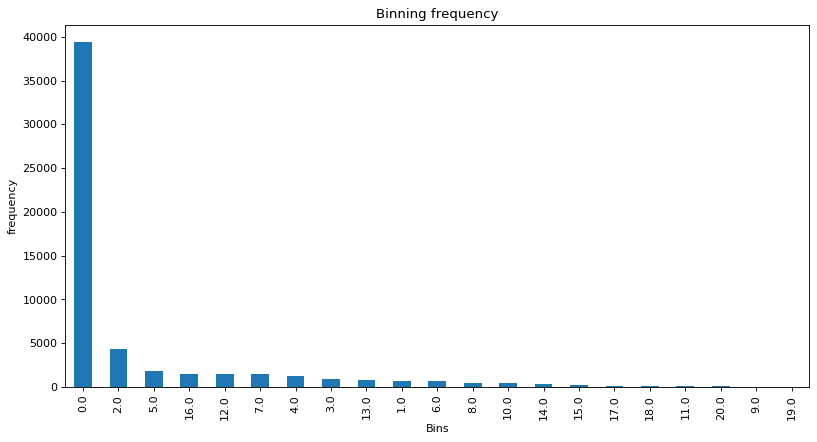

,#anonymous_gsa_id,contig,genome_id,tax_id,sequence_id,number_reads,contig_length,Busybee_bin0Percent,Busybee_bin20Percent
0,S|S1|C0,AGTAATAAGCGCCCGTTTCGCAGTCATTATAAAATCTCCCTTTTCA...,1394711.1,1394711,NC_023004.1,4,186,0.0,0.0


In [48]:
# read output of busybee method and append to contigs data frame.
busybee_20_percent = f"./Binning/{Dataset_Name}/Binning_busybee_20Percent/Output/contigs.tab"
busybee_table_20_percent = f"./Binning/{Dataset_Name}/Binning_busybee_20Percent/Output/binning/contigs.bin.table.tsv"

contig2Id = pd.read_csv(busybee_20_percent, sep='\t', header=None)
contig2Id.columns = ['#anonymous_gsa_id', 'id']

ID2Bin = pd.read_csv(busybee_table_20_percent, sep='\t', header=None)
ID2Bin.columns = ['id', 'Busybee_bin20Percent']

Busybee_bin = pd.merge(contig2Id, ID2Bin, how='outer', on='id')
Busybee_bin = Busybee_bin.drop(['id'], axis=1)

## merge contigs and genome_id
contigs = pd.merge(contigs, Busybee_bin, how='outer', on='#anonymous_gsa_id')
contigs['Busybee_bin20Percent'] = contigs['Busybee_bin20Percent'].fillna(0)

del(contig2Id, ID2Bin, Busybee_bin)
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
ax = contigs['Busybee_bin20Percent'].value_counts().plot(
    kind='bar', title='Binning frequency')
plt.xlabel('Bins')
plt.ylabel('frequency')
plt.savefig(f"./Output/{Dataset_Name}/figs/busybee_binning20_frequency.svg")
plt.show()

contigs.head(1)

In [49]:
#CAMI binning Bioboxes format
busybee_20_percent_output = f"./Temp/{Dataset_Name}/Busybee20"

df = contigs[['#anonymous_gsa_id', 'Busybee_bin20Percent']]
df[df["Busybee_bin20Percent"] != 0].to_csv(busybee_20_percent_output,
                                           index=None,
                                           sep='\t')

with open(busybee_20_percent_output, 'r') as file:
    file.readline()
    text = file.read()
    
with open(busybee_20_percent_output, 'w', encoding='utf8') as file:
    file.write("@Version:0.9.1\n@SampleID:gsa\n\n@@SEQUENCEID\tBINID\n" + text)

## Busybee method with threshold 50%

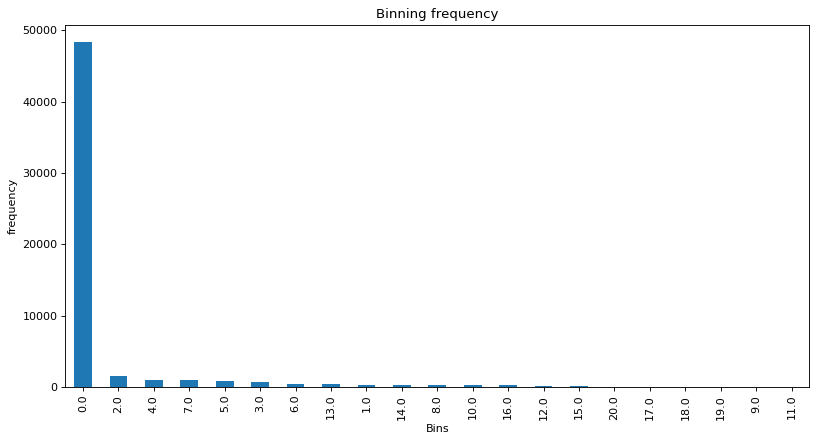

,#anonymous_gsa_id,contig,genome_id,tax_id,sequence_id,number_reads,contig_length,Busybee_bin0Percent,Busybee_bin20Percent,Busybee_bin50Percent
0,S|S1|C0,AGTAATAAGCGCCCGTTTCGCAGTCATTATAAAATCTCCCTTTTCA...,1394711.1,1394711,NC_023004.1,4,186,0.0,0.0,0.0


In [50]:
# read output of busybee method and append to contigs data frame.
busybee_50_percent = f"./Binning/{Dataset_Name}/Binning_busybee_50Percent/Output/contigs.tab"
busybee_table_50_percent = f"./Binning/{Dataset_Name}/Binning_busybee_50Percent/Output/binning/contigs.bin.table.tsv"

contig2Id = pd.read_csv(busybee_50_percent, sep='\t', header=None)
contig2Id.columns = ['#anonymous_gsa_id', 'id']

ID2Bin = pd.read_csv(busybee_table_50_percent, sep='\t', header=None)
ID2Bin.columns = ['id', 'Busybee_bin50Percent']

Busybee_bin = pd.merge(contig2Id, ID2Bin, how='outer', on='id')
Busybee_bin = Busybee_bin.drop(['id'], axis=1)

## merge contigs and genome_id
contigs = pd.merge(contigs, Busybee_bin, how='outer', on='#anonymous_gsa_id')
contigs['Busybee_bin50Percent'] = contigs['Busybee_bin50Percent'].fillna(0)

del(contig2Id, ID2Bin, Busybee_bin)
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
ax = contigs['Busybee_bin50Percent'].value_counts().plot(
    kind='bar', title='Binning frequency')
plt.xlabel('Bins')
plt.ylabel('frequency')
plt.savefig(f"./Output/{Dataset_Name}/figs/busybee_binning50_frequency.svg")
plt.show()
contigs.head(1)

In [51]:
#CAMI binning Bioboxes format
busybee_50_percent_output = f"./Temp/{Dataset_Name}/Busybee50"
df = contigs[['#anonymous_gsa_id', 'Busybee_bin50Percent']]
df[df["Busybee_bin50Percent"] != 0].to_csv(busybee_50_percent_output,
                                           index=None,
                                           sep='\t')
with open(busybee_50_percent_output, 'r') as file:
    file.readline()
    text = file.read()
with open(busybee_50_percent_output, 'w', encoding='utf8') as file:
    file.write("@Version:0.9.1\n@SampleID:gsa\n\n@@SEQUENCEID\tBINID\n" + text)

# Gene Ontology
## https://www.ebi.ac.uk/QuickGO/api/index.html#/gene_ontology

In [52]:
annotation_go = f"./Annotation/{Dataset_Name}/data/cds.gene2go.tab.txt"
go = pd.read_csv(annotation_go,sep='\t')
print(f'gene2go table shape is : {go.shape}')
print(f'The number of contigs to which a GO term assigned is : {len(go["Contig"].unique())}')
print(f'The number of unique GO term assigned is : {len(go["go_id"].unique())}')
go.head(1)

gene2go table shape is : (289891, 11)
The number of contigs to which a GO term assigned is : 24075
The number of unique GO term assigned is : 6745


,#Gene,Contig,Start,End,Gene_Length,Strand,SP,TM,go_id,Taxonomy,Terms
0,metaerg.pl|00001,S|S1|C4223,71,1423,1353,1,No,0,GO:0005524,ATP binding,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...


In [53]:
annotation_go_profile = f"./Annotation/{Dataset_Name}/data/go.cds.profile.tab.txt"
go_profile = pd.read_csv(annotation_go_profile,sep='\t')
go_profile = go_profile.sort_values(by ='Count' ,ascending=False)
go_profile.head(1)

,#GO_id,Name,Count,Count_pct,Abund,Abund_pct
5957,GO:0005737,cytoplasm,11991,10.98,0,0


5.0


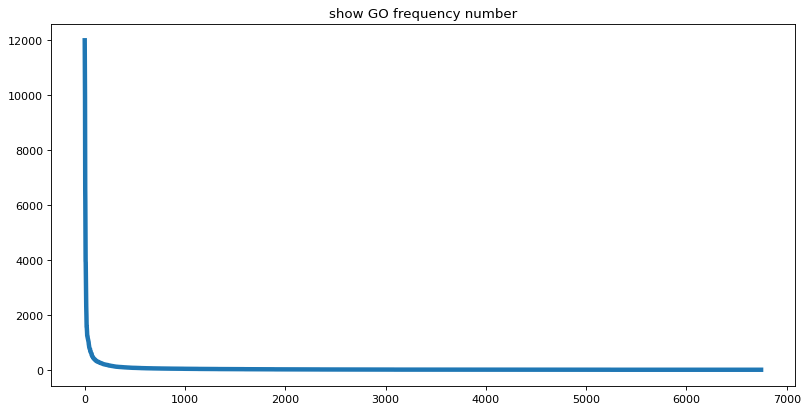

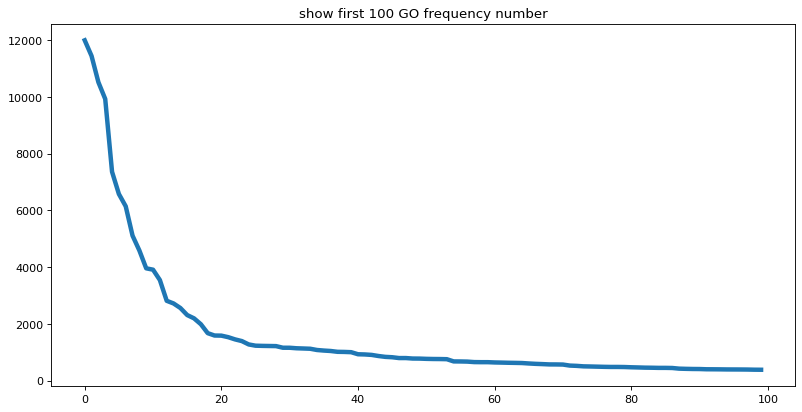

In [54]:
linewidth = 4
print(np.median(list(go['go_id'].value_counts())))
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(list(go['go_id'].value_counts()),linewidth=linewidth)
plt.title('show GO frequency number')
plt.savefig(f"./Output/{Dataset_Name}/figs/GO_frequency_number.svg")
plt.show()

plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(list(go['go_id'].value_counts()[:100]),linewidth=linewidth)
plt.title('show first 100 GO frequency number')
plt.savefig(f"./Output/{Dataset_Name}/figs/first_100_GO_frequency_number.svg")
plt.show()

## Add namespace [ cc, bp, mf ]

In [55]:
# function to get accession and return namespace
accession_to_namespace = dict()
go_graph = obonet.read_obo('./go.obo') 
go_ids = go['go_id'].unique()
for accession in go_ids:
    try:        
        accession_to_namespace[accession] =  go_graph.nodes[accession]['namespace']
    except: # if not exist,store in list to get from API                        
        r = requests.get("https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/" + accession
                     , headers={ "Accept" : "application/json"})
        if not r.ok:
            print(f'Not found ', r.raise_for_status())                                              
        else:
            accession_to_namespace[accession]= r.json()['results'][0]['aspect']         

In [56]:
l = list()
def get_namespace(accession):
    if(accession in accession_to_namespace):        
        return accession_to_namespace[accession]
    l.append(accession)
    return None

go['Namespace'] = go['go_id'].apply(lambda x : get_namespace(x) )
print(go['Namespace'].value_counts())
go.head(2)

molecular_function    139288
biological_process     95557
cellular_component     55046
Name: Namespace, dtype: int64


,#Gene,Contig,Start,End,Gene_Length,Strand,SP,TM,go_id,Taxonomy,Terms,Namespace
0,metaerg.pl|00001,S|S1|C4223,71,1423,1353,1,No,0,GO:0005524,ATP binding,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...,molecular_function
1,metaerg.pl|00001,S|S1|C4223,71,1423,1353,1,No,0,GO:0005737,cytoplasm,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...,cellular_component


# Visbin

anonymous.fasta  mapping.tsv


In [ ]:
!java -jar VizBin-dist.jar -Dtextfield_file=./Dataset/Toy_Low/anonymous.fasta  

2021-05-23 14:03:11,018 DEBUG [main] (MainFrame.java:109) - Init of Main application frame
2021-05-23 14:03:11,590 DEBUG [main] (MainFrame.java:114) - Property changed: defaultCloseOperation. Old: 1 New: 3
2021-05-23 14:03:12,692 DEBUG [main] (MainFrame.java:114) - Property changed: font. Old: null New: java.awt.Font[family=Dialog,name=Dialog,style=plain,size=12]
2021-05-23 14:03:12,694 DEBUG [main] (MainFrame.java:114) - Property changed: foreground. Old: null New: java.awt.SystemColor[i=9]


# Our Method

## Create dictionary BP, CC , MF base of GOGO for each pair of go ids

In [57]:
def runGOGO(i,namespace):        
    %cd ./GOGO/
    !perl go_comb.pl ../Temp/{Dataset_Name}/{namespace}/go_ids{i}.txt ../Temp/{Dataset_Name}/{namespace}/go_ids_scores{i}
    %cd ..    

In [58]:
def Step1(namespace):    
    !rm -r ./Temp/{Dataset_Name}/{namespace}/ 
    !mkdir ./Temp/{Dataset_Name}/{namespace}/
    # first create all possible pairs of GOs for Biological Process
    go_ids = go[go["Namespace"] == namespace]['go_id'].unique()    
    go1 = []
    go2 = []
    for i in range(0,go_ids.shape[0]):
        for j in range(i, go_ids.shape[0]):            
            go1.append(go_ids[i])
            go2.append(go_ids[j])
    df = pd.DataFrame({'goid1': go1,'goid2': go2},columns = ['goid1', 'goid2'])
    indexes = np.linspace(0,df.shape[0], num_cores + 1) // 1
    indexes[-1] =  df.shape[0]
    for i in range(0, num_cores):
        dfi = df.iloc[int(indexes[i]):int(indexes[i+1]),:]
        dfi.to_csv(f"./Temp/{Dataset_Name}/{namespace}/go_ids{i}.txt",sep=" ",index=None,header=None)
        
    # now run GOGO in multiprocessing
    if __name__ == '__main__':        
        pool = mp.Pool(num_cores)        
        pool.map(partial(runGOGO, namespace=namespace), range(0,num_cores))      
        
    clear_output()

In [59]:
def Step2(namespace):            
    def add2dict(row, dictionary):
        dictionary[row[0]+row[1]] = row[3]
        dictionary[row[1]+row[0]] = row[3]
        
    lines = []
    for i in range(0,num_cores):
        with open(f"./Temp/{Dataset_Name}/{namespace}/go_ids_scores{i}","r") as f:
            text = f.read()
            lines = [*lines, *[l for l in text.split("\n") if len(l) > 0 and l[-24:] != "not_in_the_same_ontology"]]                        
            
    df = pd.read_csv(StringIO('\n'.join(lines)), sep=" ", header=None)                
    dictionary = dict()    
    df.apply(lambda row:add2dict(row, dictionary), axis=1)
               
    with open(f"./Temp/{Dataset_Name}/{namespace}.pkl", "wb") as file:
        pickle.dump(dictionary, file)        
    !rm -r ./Temp/{Dataset_Name}/{namespace}/    

### biological process

In [60]:
Step1("biological_process")

In [ ]:
Step2("biological_process")

### cellular component

In [ ]:
Step1("cellular_component")

In [ ]:
Step2("cellular_component")

### molecular function

In [ ]:
Step1("molecular_function")

In [ ]:
Step2("molecular_function")

## Select unlabled contigs

In [ ]:
unlabelled0 = contigs[contigs['Busybee_bin0Percent']==0] 
unlabelled20 = contigs[contigs['Busybee_bin20Percent']==0] 
unlabelled50 = contigs[contigs['Busybee_bin50Percent']==0]
n=contigs.shape[0];n0= unlabelled0.shape[0];n20=unlabelled20.shape[0];n50=unlabelled50.shape[0];
print(f'''Number of unlable for:
            bussybee 0% :     {n0}    {round(n0*100/n,2)}% unassigned
            bussybee 20% :    {n20}    {round(n20*100/n,2)}% unassigned
            bussybee 50% :    {n50}    {round(n50*100/n,2)}% unassigned''')

def contigs_with_go(df):
    return len(set(df['#anonymous_gsa_id']).intersection(set(go['Contig'])))

print(f'Contigs with go for: \t0% : {contigs_with_go(unlabelled0)}\t,20% : {contigs_with_go(unlabelled20)}\t,50% : {contigs_with_go(unlabelled50)}')

## Load data

In [ ]:
number_of_bins = int(max(contigs['Busybee_bin50Percent']))

bins = [0 for i in range(0,number_of_bins + 1)]
for i in range(0, number_of_bins):    
    cnt = contigs[contigs['Busybee_bin50Percent'] == (i+1)] # select contigs where bin_id = i
    bins[i] = pd.merge(go, cnt, how="inner", 
                    left_on='Contig',
                    right_on="#anonymous_gsa_id")#['go_id'].value_counts()        
        
with open(f"./Temp/{Dataset_Name}/biological_process.pkl", "rb") as file:
    bp_dictionary = pickle.load(file)

with open(f"./Temp/{Dataset_Name}/cellular_component.pkl", "rb") as file:
    cc_dictionary = pickle.load(file)
    
with open(f"./Temp/{Dataset_Name}/molecular_function.pkl", "rb") as file:
    mf_dictionary = pickle.load(file)

## Disjoint

### 16S

In [51]:
with open("Annotation/Toy_Low/data/16SrRNA.ffn", "r") as file:    
    lines = [t for t in file.read().split('\n') if len(t) > 0]
    lines = [t for t in lines if t[0] == '>']
    rRNA16S = pd.read_csv(StringIO('\n'.join(lines)), sep="/", header=None)                
    rRNA16S = rRNA16S.iloc[:,1:]
    rRNA16S.columns = ["Name", "rRNA_taxon", "cid"]
    rRNA16S["Name"] = rRNA16S["Name"].apply(lambda x : x.replace("Name=",""))
    rRNA16S["rRNA_taxon"] = rRNA16S["rRNA_taxon"].apply(lambda x : x.replace("rRNA_taxon=",""))
    rRNA16S["cid"] = rRNA16S["cid"].apply(lambda x : x.replace("cid=",""))
print(rRNA16S.shape)
rRNA16S.head()

(71, 3)


,Name,rRNA_taxon,cid
0,bac_16SrRNA,Bacteria;Firmicutes;Bacilli;Bacillales;Bacilla...,S|S1|C4223
1,bac_16SrRNA,Bacteria;Firmicutes;Bacilli;Bacillales;Bacilla...,S|S1|C4223
2,bac_16SrRNA,Bacteria;Firmicutes;Bacilli;Bacillales;Bacilla...,S|S1|C4223
3,bac_16SrRNA,Bacteria;Firmicutes;Bacilli;Bacillales;Bacilla...,S|S1|C4223
4,bac_16SrRNA,Bacteria;Firmicutes;Bacilli;Bacillales;Bacilla...,S|S1|C4223


In [57]:
bins = [[] for i in range(0,number_of_bins+1)]
for i in range(1, number_of_bins+1):
    df = contigs[contigs['Busybee_bin50Percent']==i]
    df = pd.merge(df, rRNA16S, how="inner", left_on="#anonymous_gsa_id", right_on="cid")    
    for index, row in df.iterrows():
        bins[i].append(row['rRNA_taxon'])    
    bins[i] = [s for s in set(bins[i])]    

In [70]:
[i for i in range(1, number_of_bins+1) if len(bins[i]) > 1]

[9, 10]

## main loop

In [123]:
number = 1000
power_coeff = 1

def getDictionary(namespace):
    if(namespace == "biological_process"):
        return bp_dictionary
    if(namespace == "cellular_component"):
        return cc_dictionary    
    if(namespace == "molecular_function"):
        return mf_dictionary
    
# this function recived a contig and return pred bin and score
def binScore(inp_bin, go_id,dictionary):        
    def run(pair):
        if(pair in dictionary):          
            return dictionary[pair] ** power_coeff
        return -1
    scores = inp_bin['go_id'].apply(lambda g: run(g + go_id))    
    scores = scores[scores>=0]    
    if(scores.shape[0] == 0):
        return 0
    return sum(sorted(scores,reverse=True)[:number]) / number

def getScore(go_id):            
    result = np.zeros(number_of_bins)    
    namespace = accession_to_namespace[go_id]
    for i in range(0,number_of_bins):
        result[i] = binScore(bins[i],
                             go_id,
                             getDictionary(namespace))
    return go_id, result

if __name__ == '__main__':
    num_cores = mp.cpu_count()
    pool = mp.Pool(num_cores - 3)    
    go_ids = pd.merge(unlabelled50,
             go,how='inner',
             left_on='#anonymous_gsa_id',
             right_on='Contig')['go_id'].unique()

    go_dictionary = dict()

    for go_id, result in pool.map(getScore, go_ids):        
        go_dictionary[go_id] = result

## Pred

In [132]:
alpha = 1  # BP
beta  = 0.5  # CC
gamma = 1  # MF

def getCoefficient(namespace):
        if(namespace == "biological_process"):
            return alpha
        if(namespace == "cellular_component"):
            return beta    
        if(namespace == "molecular_function"):
            return gamma    
    
def pred(cnt):                                
    coeff = 0
    selected = go[go['Contig'] == cnt]
    go_ids = selected['go_id']            
    go_namespace = selected['Namespace']            
    result = np.zeros((go_ids.shape[0], number_of_bins))    
    for i in range(0,len(go_ids.index)):  
        index = go_ids.index[i]       
        namespace = go_namespace[index]
        coeff += getCoefficient(namespace)                                         
        result[i,:] = go_dictionary[go_ids[index]] * getCoefficient(namespace)                 
    score = sum(result) / coeff if coeff != 0 else sum(result) * 0    
    index = np.where(score == max(score))[0][0] + 1                
    return index, max(score), cnt    

if __name__ == '__main__':
    answer = {}    
    num_cores = mp.cpu_count()
    pool = mp.Pool(num_cores - 3)    
    unlabelledContigs = pd.Series(list(set(unlabelled50['#anonymous_gsa_id']).intersection(set(go['Contig']))))        
    for index, score, cnt in pool.map(pred,unlabelledContigs):        
        answer[cnt] = (index,  score)

In [142]:
threshold = 0.41
counter = 0
def assign(row):
    global counter
    cnt = row['#anonymous_gsa_id']
    if(cnt in answer and answer[cnt][1] >= threshold):                
        counter += 1
        return answer[row['#anonymous_gsa_id']][0]    
    return row['Busybee_bin50Percent']

contigs['OurMethod'] = contigs.apply(lambda row:assign(row),axis=1)    
print(counter)
sum(contigs['OurMethod'] == 0)

11992


36368

In [143]:
#CAMI binning Bioboxes format
OurMethod_output =  f"./Temp/{Dataset_Name}/OurMethod"

df = contigs[['#anonymous_gsa_id','OurMethod']]
df[df["OurMethod"]!= 0].to_csv(OurMethod_output,index=None, sep='\t')
with open(OurMethod_output,'r') as file:
    file.readline()
    text = file.read()
with open(OurMethod_output,'w',encoding='utf8') as file:
    file.write("@Version:0.9.1\n@SampleID:gsa\n\n@@SEQUENCEID\tBINID\n" + text)

In [144]:
!amber.py -g ./Temp/{Dataset_Name}/gold_standard -o ./Output/{Dataset_Name}/Assesment/  ./Temp/{Dataset_Name}/Busybee0  ./Temp/{Dataset_Name}/OurMethod

2021-05-17 16:29:01,676 INFO Loading Gold standard
2021-05-17 16:29:01,812 INFO Loading Busybee0
2021-05-17 16:29:01,869 INFO Loading OurMethod.txt
2021-05-17 16:29:01,924 INFO Creating output directories
2021-05-17 16:29:01,926 INFO Evaluating Gold standard (sample gsa, genome binning)
2021-05-17 16:29:02,241 INFO Evaluating Busybee0 (sample gsa, genome binning)
2021-05-17 16:29:02,522 INFO Evaluating OurMethod.txt (sample gsa, genome binning)
2021-05-17 16:29:02,788 INFO Saving computed metrics
2021-05-17 16:29:02,810 INFO Creating genome binning plots
2021-05-17 16:29:17,951 INFO Creating HTML page
2021-05-17 16:29:19,462 INFO AMBER finished successfully. All results have been saved to /home/jupyter/Final/Output/Toy_Low/Assesment


# Visualization

In [ ]:
#!wget https://github.com/claczny/VizBin/releases/download/v1.0.0/VizBin-dist.jar

In [145]:
!java -jar ./VizBin-dist.jar

/bin/bash: java: command not found


# KEGG

In [ ]:
kegg = pd.read_csv('./Annotation/Toy_low/data/cds.gene2kegg.tab.txt',sep='\t')
print(kegg.shape)
kegg = pd.merge(kegg,Geneid2Contigid,how='inner',on='#Geneid')
kegg.head(2)

In [ ]:
print(np.median(list(kegg['Kegg_id'].value_counts())))
plt.plot(list(kegg['Kegg_id'].value_counts()))
plt.show()

# KO

In [ ]:
ko = pd.read_csv('./Annotation/Toy_low/data/cds.gene2ko.tab.txt',sep='\t')
print(ko.shape)
ko.head(5)

In [ ]:
print(np.median(list(ko['koid'].value_counts())))
plt.plot(list(ko['koid'].value_counts()))
plt.show()

In [ ]:
print(np.median(list(ko['Contig'].value_counts())))
plt.plot(list(ko['Contig'].value_counts()))
plt.show()

In [ ]:
df = pd.read_csv('./Annotation/Toy_low/data/cds.gene2sprot.tab.txt',sep='\t')
print(df.shape)
df.head(2)

In [ ]:
uniprot = pd.read_csv('./uniprot-filtered-reviewed-yes.tab',sep='\t')
print(uniprot.shape)
uniprot.head(2)

In [ ]:
df = pd.merge(uniprot,df,how='inner',left_on='Protein names',right_on='sprot_desc')
print(df.shape)
df.head(2)

# Gene id  to contig id maper

In [ ]:
with open('./Annotation/{Dataset_Name}/data/cds.faa', 'r') as file:     
    lines = [line.split('\n')[0] for line in file.read().split('>') if len(line) > 0]    
    data = {'#Geneid': [l.split(' ')[0] for l in lines],
        'Contigid': [l.split(' ')[-1][4:] for l in lines]}
    Geneid2Contigid = pd.DataFrame(data, columns = ['#Geneid', 'Contigid'])
Geneid2Contigid.head(2)

In [ ]:
plt.plot(np.linspace(0,1,1000),np.linspace(0,1,1000) ** 1, 'r')
plt.plot(np.linspace(0,1,1000),np.linspace(0,1,1000) ** 10, 'g')